In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from einops import rearrange
from random import randint
from dataset import ImageDataset
from vit_trainer import VitTrainer

import matplotlib.pyplot as plt
import numpy as np

from utils import permute_image, topk_acc, greedy_refine_pred_perm

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [40]:
vit_trainer = VitTrainer.load_from_checkpoint('logs/kf2x907t-484-ep78.ckpt')
cfg = vit_trainer.cfg

vit = vit_trainer.model.to(device)
vit = vit.eval()
# vit = vit.train()
dataset = ImageDataset(cfg.data_dir, cfg.image_paths_pkl)

Selected index: 50398


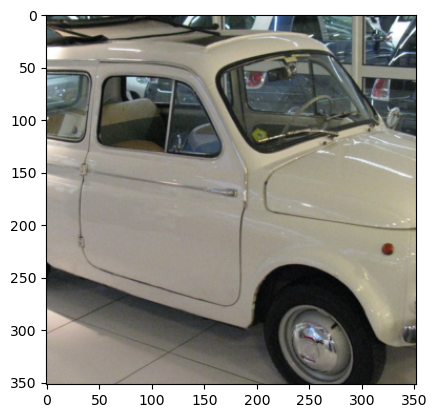

In [24]:
# idx = randint(0, len(dataset) - 1)
idx = 50398
print(f'Selected index: {idx}')
img = vit_trainer.resize_image(dataset[idx])

plt.imshow(img.permute(1, 2, 0))
plt.show()

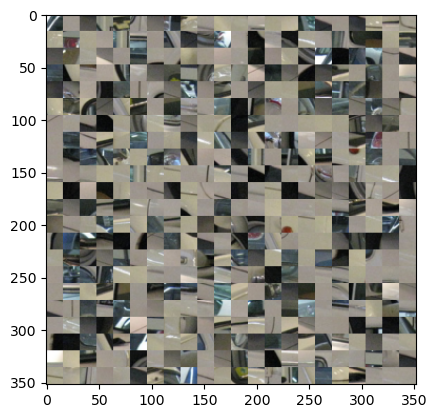

In [56]:
if False:
    gt_perm = torch.arange(cfg.num_patches)
else:
    gt_perm = None

p_img, gt_perm = permute_image(img, patch_size=cfg.patch_size, perm=gt_perm)
plt.imshow(p_img.permute(1, 2, 0))
plt.show()

In [57]:
with torch.no_grad():
    x = p_img.unsqueeze(0).to(device)
    x = vit_trainer.image_transforms(x)
    y = vit(x)
pred_perm = y.squeeze().argmax(dim=-1)
pred_perm

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20, 263,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85, 328, 329,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 371, 130, 373, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [58]:
gt = vit_trainer.gt_single[:, gt_perm].expand(y.size(0), -1)
# gt = vit_trainer.gt_single[:].expand(y.size(0), -1)
t1_acc = topk_acc(y, gt, k=1)
t5_acc = topk_acc(y, gt, k=5)
print(f'Top-1 accuracy: {t1_acc:.4f}')
print(f'Top-5 accuracy: {t5_acc:.4f}')

Top-1 accuracy: 0.0021
Top-5 accuracy: 0.0124


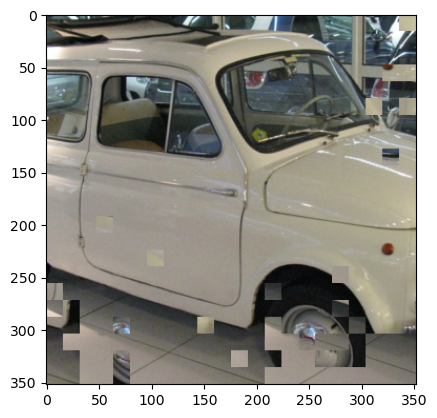

In [59]:
recon_image, _ = permute_image(img, cfg.patch_size, pred_perm)
plt.imshow(recon_image.permute(1, 2, 0))
plt.show()

# permutation equivariance!

# Normal transformer:
# in:  a b c
# out: 0 1 2

# in:  b a c
# out: 1 0 2


#  UPDATE: train/eval mode doesn't really matter.

# in:  [a, b, c]
# out: [0, 1, 2]

# p_in:   [b, a, c]
# want:   [1, 0, 2]
# actual: [0, 1, 2]

# Somehow, the ViT managed to become perm invariant?


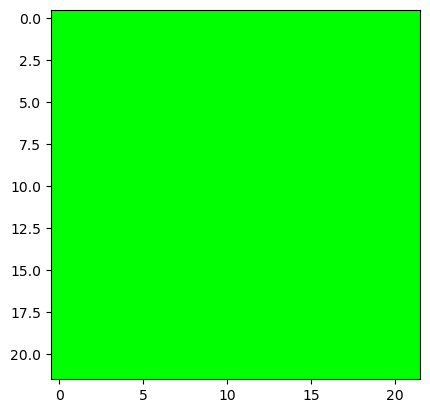

In [65]:
# Visualize the top-1 error locations
# If a patch position is predicted wrong, it will be colored red
# Otherwise, it will be colored green.


def visualize_top1_error(recon_image, pred_perm: torch.tensor, gt_perm: torch.tensor):
    gt_perm = gt_perm.squeeze()
    n_side = cfg.crop_image_to_px // cfg.patch_size
    errors = torch.where(pred_perm != gt_perm)[0]

    r = errors // n_side
    c = errors % n_side

    overlay = torch.zeros((n_side, n_side, 3), dtype=torch.float32)
    overlay[:] = torch.tensor([0, 1, 0], dtype=torch.float32)
    overlay[r, c] = torch.tensor([1, 0, 0], dtype=torch.float32)

    # Blend the overlay with the image
    # recon_image = recon_image.permute(1, 2, 0).cpu().numpy()

    plt.imshow(overlay)
    plt.show()


visualize_top1_error(recon_image, pred_perm, gt)

In [66]:
y_p = torch.nn.functional.softmax(y, dim=-1).squeeze()

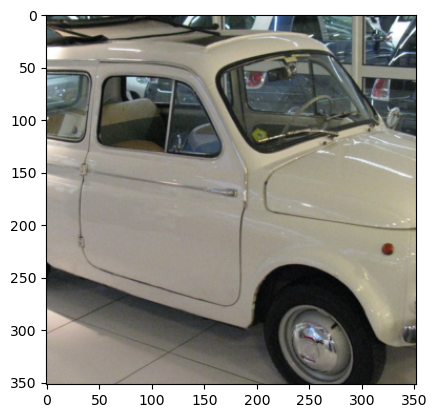

In [67]:
refined_pred_perm = greedy_refine_pred_perm(y_p)
refined_recon_image, _ = permute_image(img, cfg.patch_size, pred_perm)
plt.imshow(refined_recon_image.permute(1, 2, 0))
plt.show()

In [48]:
a = torch.rand(5)
a

tensor([0.6409, 0.4999, 0.4740, 0.1275, 0.5542])

In [49]:
a[[4, 3, 2, 1, 0]]

tensor([0.5542, 0.1275, 0.4740, 0.4999, 0.6409])

In [22]:
print(vit)

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=16, p2=16)
    (1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (2): Linear(in_features=768, out_features=1024, bias=True)
    (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (transformer): Transformer(
    (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (layers): ModuleList(
      (0-5): 6 x ModuleList(
        (0): Attention(
          (norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (attend): Softmax(dim=-1)
          (to_qkv): Linear(in_features=1024, out_features=3072, bias=False)
          (to_out): Linear(in_features=1024, out_features=1024, bias=False)
        )
        (1): FeedForward(
          (net): Sequential(
            (0): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=1024, out_features=2048, bias=True)
            (2): GELU(approximate='none')
  